[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/road_segmentation.ipynb)

# Road Segmentation

In this example we are going to train a Deep Learning model to find roads in satellite imagery, following the work [here](https://github.com/aavek/Satellite-Image-Road-Segmentation/tree/main?tab=readme-ov-file).

## Dataset

The dataset we are going to use is the [Deep Globe Road Extraction](https://www.eotdl.com/datasets/DeepGlobeRoadExtraction) dataset. It contains 6226 satellite imagery in RGB, size 1024x1024, at 50cm pixel resolution, collected by DigitalGlobe's satellite.

> We are going to download the dataset from the [EOTDL](https://www.eotdl.com/), so you will need to install the library with `pip install eotdl`.

In [3]:
from pytorch_eo.datasets import DeepGlobeRoadExtraction

ds = DeepGlobeRoadExtraction(batch_size=5)

ds.setup()

In [2]:
ds.df

image  \
0     data/DeepGlobeRoadExtraction/train/100034_sat.jpg   
1     data/DeepGlobeRoadExtraction/train/100081_sat.jpg   
2     data/DeepGlobeRoadExtraction/train/100129_sat.jpg   
3     data/DeepGlobeRoadExtraction/train/100703_sat.jpg   
4     data/DeepGlobeRoadExtraction/train/100712_sat.jpg   
...                                                 ...   
6221  data/DeepGlobeRoadExtraction/train/999431_sat.jpg   
6222  data/DeepGlobeRoadExtraction/train/999531_sat.jpg   
6223  data/DeepGlobeRoadExtraction/train/999667_sat.jpg   
6224  data/DeepGlobeRoadExtraction/train/999764_sat.jpg   
6225   data/DeepGlobeRoadExtraction/train/99995_sat.jpg   

                                                   mask  
0     data/DeepGlobeRoadExtraction/train/100034_mask...  
1     data/DeepGlobeRoadExtraction/train/100081_mask...  
2     data/DeepGlobeRoadExtraction/train/100129_mask...  
3     data/DeepGlobeRoadExtraction/train/100703_mask...  
4     data/DeepGlobeRoadExtraction/train/100712_mask...  
...                                                 ...  
6221  data/DeepGlobeRoadExtraction/train/999431_mask...  
6222  data/DeepGlobeRoadExtraction/train/999531_mask...  
6223  data/DeepGlobeRoadExtraction/train/999667_mask...  
6224  data/DeepGlobeRoadExtraction/train/999764_mask...  
6225  data/DeepGlobeRoadExtraction/train/99995_mask.png  

[6226 rows x 2 columns]

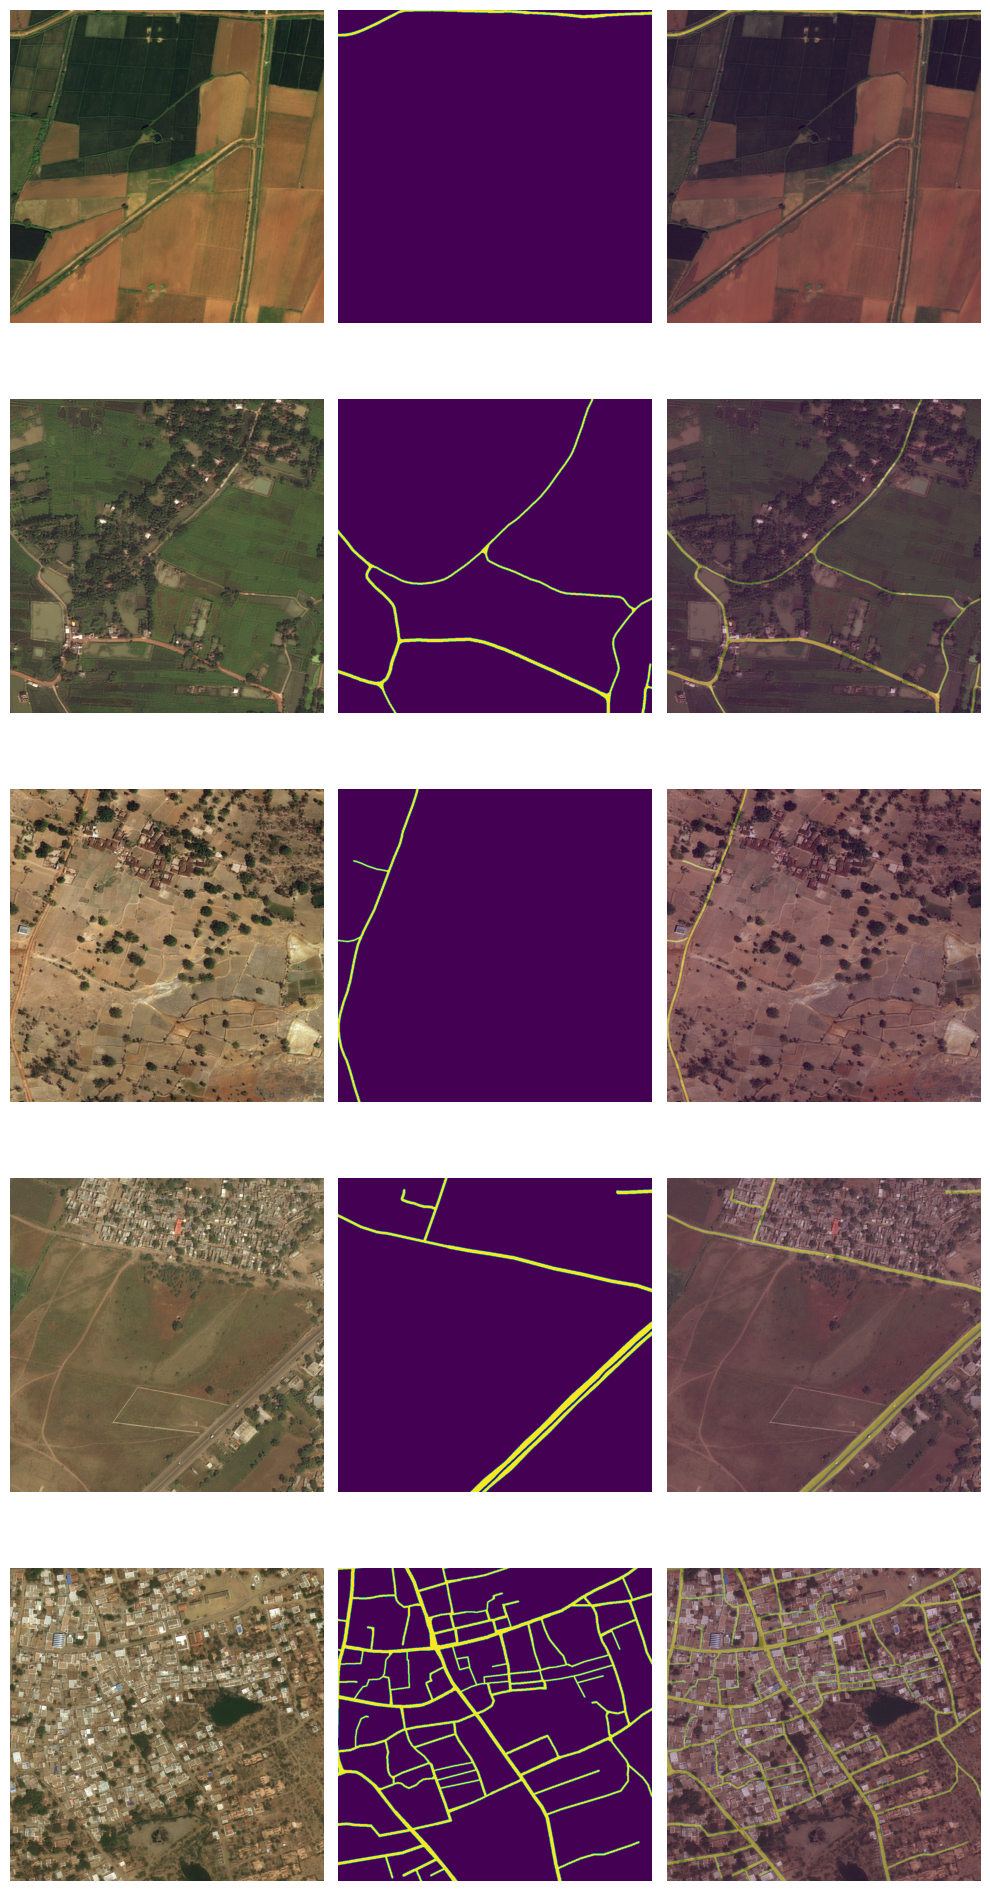

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

batch = next(iter(ds.train_dataloader()))
imgs, masks = batch['image'], batch['mask']

imgs = rearrange(imgs, 'b c h w -> b h w c')
masks = masks.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    ax.imshow(mask)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(img)
    ax.imshow(mask, alpha=0.3)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Training

We are going to train a U-Net model with default parameters. You can see an advanced example in [road_segmentation.py](./road_segmentation.py).

In [4]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_eo.tasks import ImageSegmentation

ds = DeepGlobeRoadExtraction(batch_size=8, num_workers=20, pin_memory=True)

task = ImageSegmentation(num_classes=ds.num_classes)

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=10,
	limit_train_batches=10, # comment this line to train on the full dataset
	limit_val_batches=10, # comment this line to validate on the full dataset
	callbacks=[
		ModelCheckpoint(
			monitor="val_iou",
			mode="max",
			save_top_k=1,
			dirpath="checkpoints",
			filename="unet-{epoch:02d}-{val_iou:.2f}",
		)
	]
)

# uncomment the following line to train the model
# trainer.fit(task, ds) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


## Evaluate

We can visualize the outputs of the model.

In [4]:
import segmentation_models_pytorch as smp
from pytorch_eo.tasks import ImageSegmentation

# load the best model (this checkpoint was generated with the training script `eoad_segmentation.py`)

model = smp.Unet(encoder_name="resnet50")
task = ImageSegmentation.load_from_checkpoint("checkpoints/unet-resnet50-epoch=08-val_iou=0.61.ckpt", model=model, num_classes=ds.num_classes)

/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


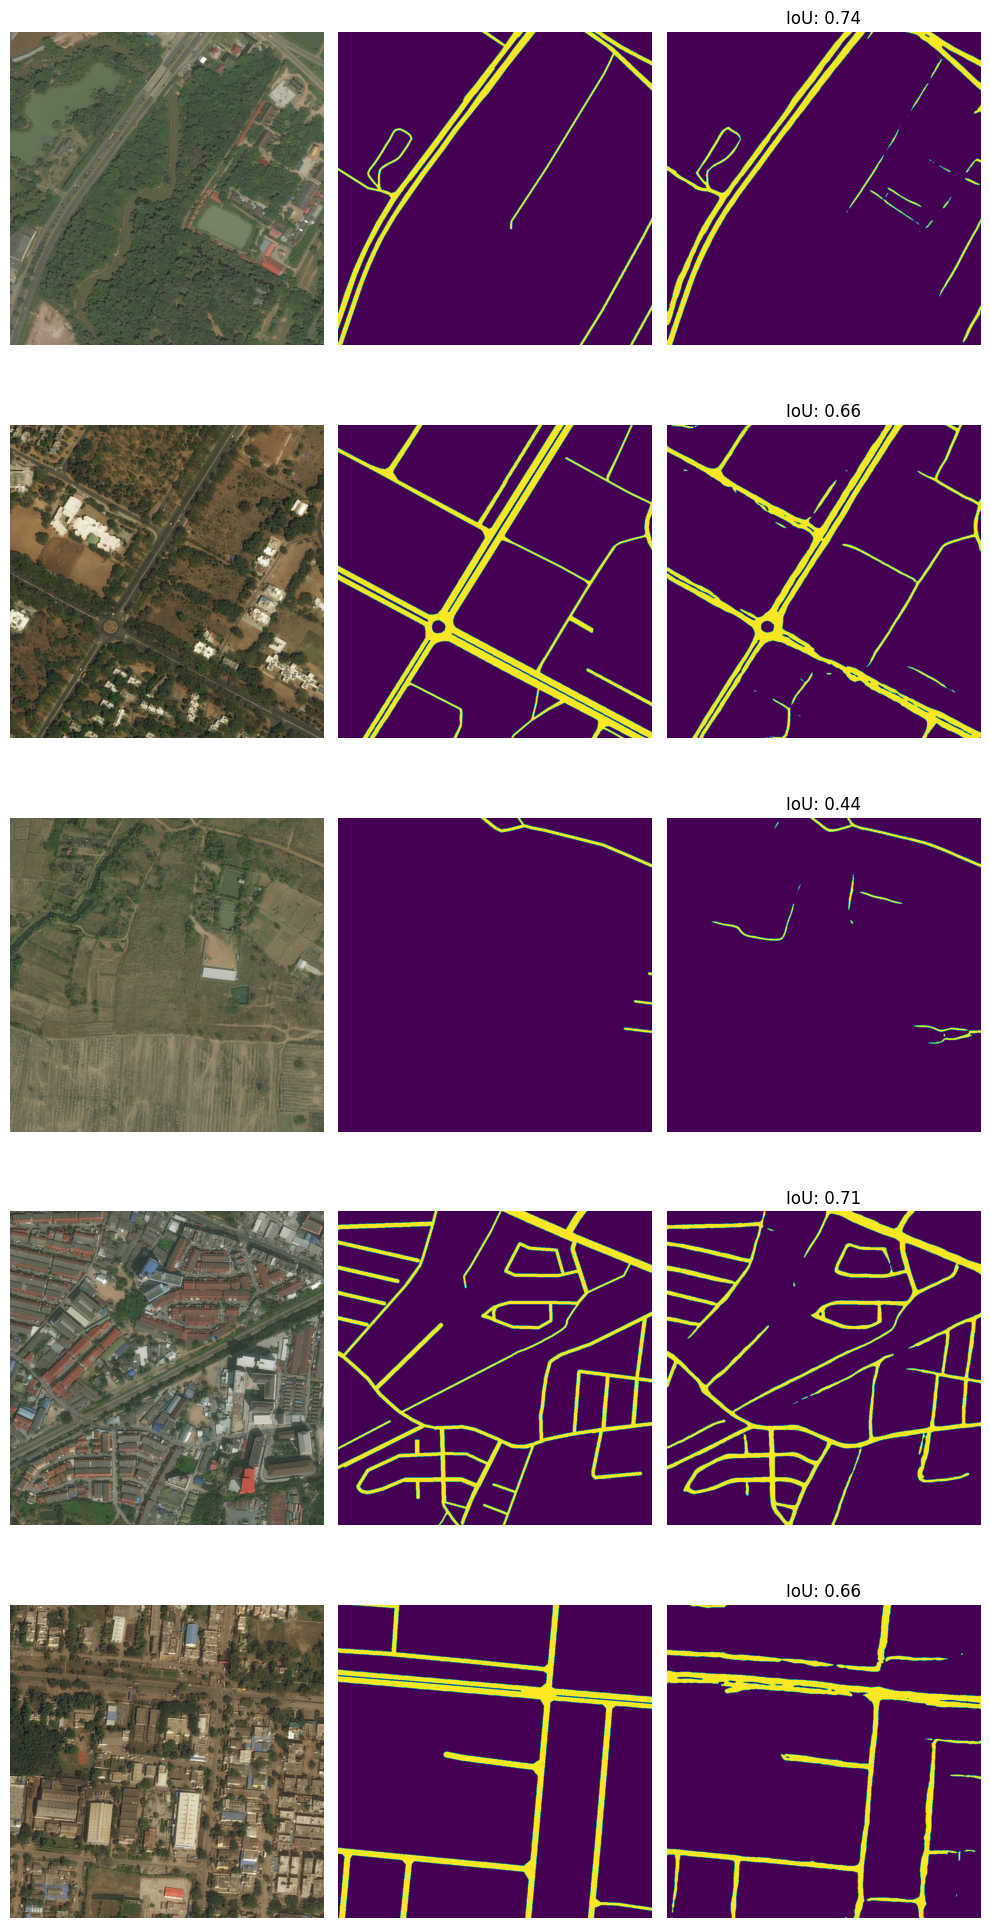

In [5]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from pytorch_eo.metrics.segmentation import iou

ds = DeepGlobeRoadExtraction(batch_size=5)
ds.setup()

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch['image'], batch['mask']

task.cpu()
preds = task.predict(batch) > 0.5

imgs = rearrange(imgs, 'b c h w -> b h w c')
masks = masks.squeeze(1)
preds = preds.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs)*4))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
    ax = plt.subplot(len(imgs), 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 2)
    ax.imshow(mask)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 3, 3*i + 3)
    ax.imshow(pred)
    _iou = iou(pred.unsqueeze(0), mask.unsqueeze(0))
    ax.set_title(f"IoU: {_iou:.2f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Export model

Now we export the model to the ONNX format and ingest it to the EOTDL platform.

In [10]:
filepath = "data/model.onnx"

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch['image'], batch['mask']

task.cpu()
task.eval()

task.to_onnx(
	filepath, 
	imgs, 
	export_params=True, 
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [11]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: imgs.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(5, 1, 1024, 1024)

In [24]:
from tqdm import tqdm

providers = [("CUDAExecutionProvider", {"device_id": torch.cuda.current_device(),
                                        "user_compute_stream": str(torch.cuda.current_stream().cuda_stream)})]
sess_options = onnxruntime.SessionOptions()
# Create the session with the options and the model file path
ort_session = onnxruntime.InferenceSession(filepath, sess_options=sess_options, providers=providers)

ious = []
pbar = tqdm(ds.val_dataloader())
for batch in pbar:
	ort_inputs = {input_name: batch['image'].numpy()}
	ort_outs = ort_session.run(None, ort_inputs)
	ious.append(iou(torch.tensor(ort_outs[0]), batch['mask']))
	pbar.set_description(f"mean IoU: {np.mean(ious):.4f}")

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider_info.cc:125 static onnxruntime::CUDAExecutionProviderInfo onnxruntime::CUDAExecutionProviderInfo::FromProviderOptions(const ProviderOptions&) [ONNXRuntimeError] : 1 : FAIL : provider_options_utils.h:148 Parse Unknown provider option: "user_compute_stream".
 when using [('CUDAExecutionProvider', {'device_id': 0, 'user_compute_stream': '0'})]
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************


mean IoU: 0.6140: 100%|██████████| 249/249 [01:12<00:00,  3.41it/s]


To ingest the model to the EOTDL platform, follow [these](https://www.eotdl.com/docs/models/ingest) instructions.